# Data-Driven Prediction of Concrete Strength Using Ensemble Machine Learning Methods

1. Import Modules

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib, os
print('Necessary imports completed')

Necessary imports completed


2. Read and Clean Data

In [16]:
df = pd.read_csv('Concrete_Data_new.csv')
print('Loaded', df.shape)
display(df.head())
#Clean up Column Names
df.columns = [
                'Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer',
                'CoarseAggregate', 'FineAggregate', 'Age', 'ConcreteStrength', 'W/C', 'BFS/C', 'FA/C'
            ]


Loaded (1030, 12)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)",Water to Cement Ratio (W/C),Blast Furnace/Cement,Fly Ash/Cement
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0.300000,0.000000,0.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,0.300000,0.000000,0.0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0.685714,0.428571,0.0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0.685714,0.428571,0.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0.966767,0.666667,0.0


3. Exploratory Data Analysis

In [3]:
print('Continue running the notebook cells as needed.')
print("Shape:", df.shape)
print(df.dtypes)
print("Missing values:\n", df.isnull().sum())
display(df.describe().T)

Continue running the notebook cells as needed.
Shape: (1030, 12)
Cement              float64
BlastFurnaceSlag    float64
FlyAsh              float64
Water               float64
Superplasticizer    float64
CoarseAggregate     float64
FineAggregate       float64
Age                   int64
ConcreteStrength    float64
W/C                 float64
BFS/C               float64
FA/C                float64
dtype: object
Missing values:
 Cement              0
BlastFurnaceSlag    0
FlyAsh              0
Water               0
Superplasticizer    0
CoarseAggregate     0
FineAggregate       0
Age                 0
ConcreteStrength    0
W/C                 0
BFS/C               0
FA/C                0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.000000,192.375000,272.900000,350.000000,540.000000
BlastFurnaceSlag,1030.0,73.895825,86.279342,0.000000,0.000000,22.000000,142.950000,359.400000
FlyAsh,1030.0,54.188350,63.997004,0.000000,0.000000,0.000000,118.300000,200.100000
Water,1030.0,181.567282,21.354219,121.800000,164.900000,185.000000,192.000000,247.000000
Superplasticizer,1030.0,6.204660,5.973841,0.000000,0.000000,6.400000,10.200000,32.200000
CoarseAggregate,1030.0,972.918932,77.753954,801.000000,932.000000,968.000000,1029.400000,1145.000000
FineAggregate,1030.0,773.580485,80.175980,594.000000,730.950000,779.500000,824.000000,992.600000
Age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
ConcreteStrength,1030.0,35.817961,16.705742,2.330000,23.710000,34.445000,46.135000,82.600000
W/C,1030.0,0.748269,0.314005,0.266893,0.533333,0.675349,0.935014,1.882353


4. Assign Target Feature

In [4]:
possible_targets = [c for c in df.columns if 'strength' in c.lower() or 'compressive' in c.lower()]
target_col = possible_targets[0] if possible_targets else df.columns[-1]
print("Target column:", target_col)

Target column: ConcreteStrength


5. Histogram Plot of all the Features

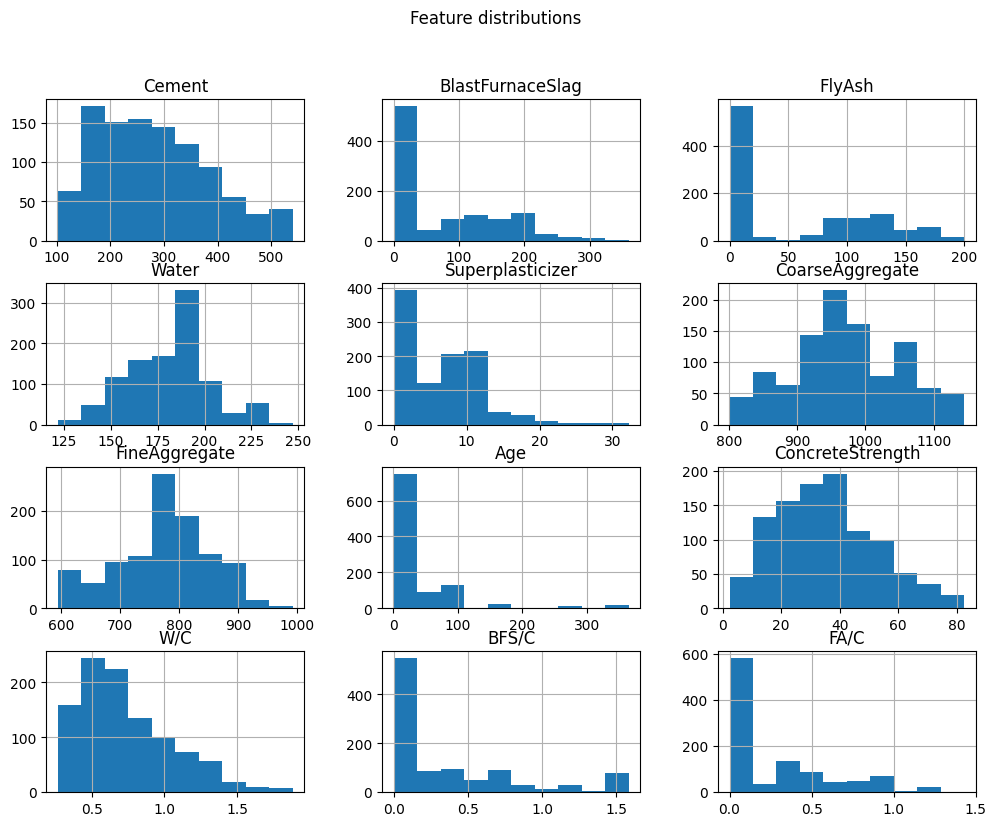

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols].hist(figsize=(12,9))
plt.suptitle("Feature distributions")
plt.show()

6. Correlation Heatmap

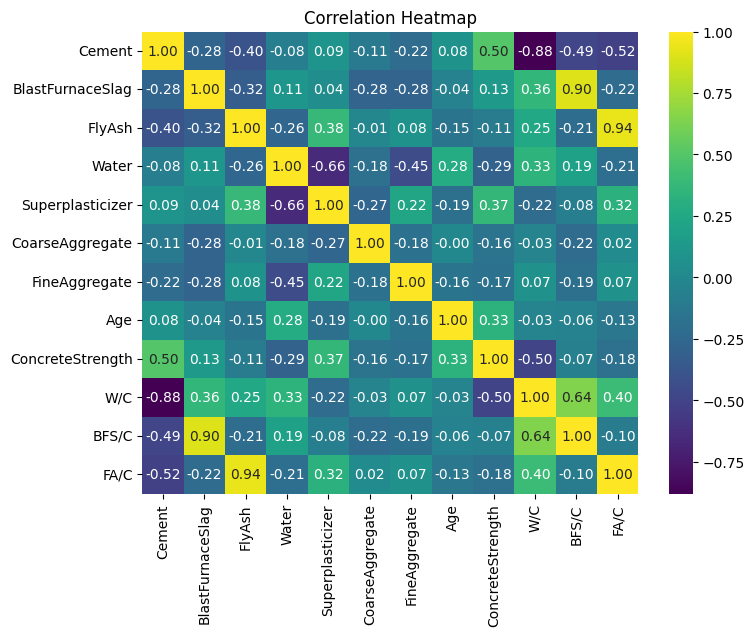

In [6]:
corr = df.corr()
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='viridis')
plt.title("Correlation Heatmap")
plt.show()

7. Preprocessing

In [7]:
# Drop rows with NA (or impute)
df = df.dropna()

# Split features & label
X = df.drop(columns=[target_col])
y = df[target_col].values

# If any non-numeric columns exist, one-hot encode
X = pd.get_dummies(X, drop_first=True)

# Train-test split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Scaling (useful for some models; tree models don't strictly need it but it's safe)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

8. Baseline Models

In [15]:

def metrics(y_true, y_pred):
    return {
        "r2": r2_score(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred))
    }

models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=200),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
}

# Create separate dictionaries to hold the results
train_results = {}
test_results = {}

for name, model in models.items():
    # 1. Fit the model
    model.fit(X_train_scaled, y_train)

    # 2. Get metrics for the TRAINING set
    train_preds = model.predict(X_train_scaled)
    train_results[name] = metrics(y_train, train_preds)
    
    # 3. Get metrics for the TESTING set 
    test_preds = model.predict(X_test_scaled)
    test_results[name] = metrics(y_test, test_preds)
    
# Convert results to DataFrames for easy viewing
train_df = pd.DataFrame(train_results).T
test_df = pd.DataFrame(test_results).T

print("Training Set Metrics")
print(train_df)
print("\nTesting Set Metrics")
print(test_df)    

Training Set Metrics
                        r2       mae       rmse
Linear            0.613611  8.199203  10.477010
RandomForest      0.986551  1.268385   1.954652
GradientBoosting  0.950145  2.811778   3.763392
CatBoost          0.988140  1.220813   1.835519

Testing Set Metrics
                        r2       mae      rmse
Linear            0.635850  7.593936  9.686747
RandomForest      0.883002  3.757059  5.490684
GradientBoosting  0.890653  3.881452  5.308127
CatBoost          0.938173  2.621457  3.991400


9. Hyperparameter tuning (RandomizedSearchCV) for CATBOOST

In [9]:
# 1. DEFINE PARAMETER DISTRIBUTION FOR CATBOOST
param_dist = {
    "iterations": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "depth": [4, 6, 8, 10],
    "subsample": [0.6, 0.8, 1.0],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "min_data_in_leaf": [1, 3, 5]
}

# Note: if dataset is small, reduce n_iter and cv:
n_samples = X.shape[0]
cv_folds = min(5, max(2, n_samples//10))  # heuristic
n_iter_search = 20 if n_samples >= 200 else 8

# 2. INSTANTIATE THE CATBOOST MODEL AND RANDOMIZEDSEARCHCV
cbr = CatBoostRegressor(random_state=42, verbose=0) # Use verbose=0 to keep output clean
rs = RandomizedSearchCV(cbr, param_distributions=param_dist,
                        n_iter=n_iter_search, cv=cv_folds, scoring='r2',
                        random_state=42, n_jobs=-1, verbose=1)

# 3. FIT THE MODEL
rs.fit(X_train_scaled, y_train)



print("Best params for CatBoost:", rs.best_params_)
best_model = rs.best_estimator_

# Evaluate best model
preds_best = best_model.predict(X_test_scaled)
metrics_best = metrics(y_test, preds_best)
print("Best CatBoost model metrics:", metrics_best)

# Cross-validated score on full dataset (optional)
cv_score = cross_val_score(best_model, scaler.transform(X), y, cv=cv_folds, scoring='r2')
print("CV R2 mean (best CatBoost model):", cv_score.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for CatBoost: {'subsample': 0.8, 'min_data_in_leaf': 5, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 6}
Best CatBoost model metrics: {'r2': 0.9406279650919045, 'mae': 2.4610821662973064, 'rmse': np.float64(3.91136824744821)}
CV R2 mean (best CatBoost model): 0.5330749881104241


10. Feature Importance and Interpretability

Age                 32.594427
W/C                 23.603232
Water                7.524565
Cement               7.511696
Superplasticizer     7.015242
FineAggregate        5.469502
BlastFurnaceSlag     5.221801
BFS/C                4.643139
CoarseAggregate      3.798116
FA/C                 1.376860
dtype: float64

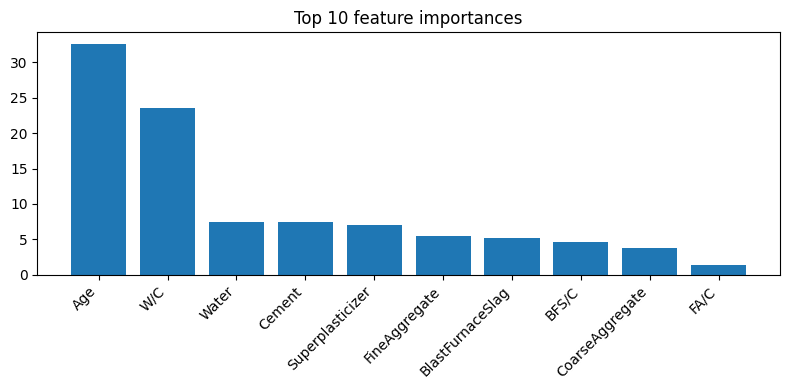

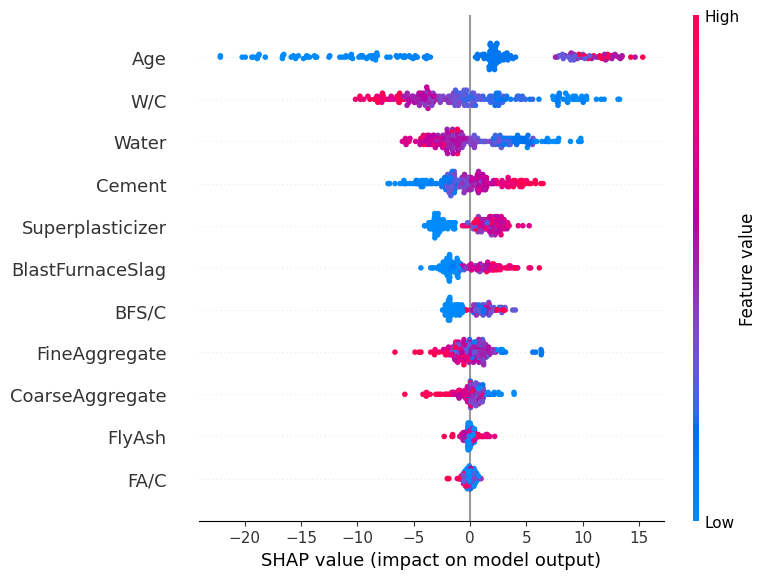

In [14]:
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.head(10))
plt.figure(figsize=(8,4))
plt.bar(importances.index[:10], importances.values[:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 feature importances")
plt.tight_layout()
plt.show()

#Run SHAP for per-sample explanations:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

11. Optimization Routine (search-based)

In [11]:
# Note: sample candidate mixes within observed ranges, predict, and pick those close to target.
feature_ranges = {col: (X[col].min(), X[col].max()) for col in X.columns}

def suggest_mixes(target_strength, n_candidates=10000, top_k=10, tolerance=None, prefer_low_cement=True):
    rng = np.random.RandomState(0)
    candidates = pd.DataFrame({col: rng.uniform(low, high, n_candidates) for col, (low, high) in feature_ranges.items()})
    # If 'Age' present, consider rounding to nearest whole day
    age_cols = [c for c in candidates.columns if 'age' in c.lower()]
    for a in age_cols:
        candidates[a] = np.clip(np.round(candidates[a]), feature_ranges[a][0], feature_ranges[a][1])
    # Predict
    cand_scaled = scaler.transform(candidates)
    preds = best_model.predict(cand_scaled)
    candidates['pred_strength'] = preds
    candidates['abs_err'] = np.abs(preds - target_strength)
    if tolerance is not None:
        candidates = candidates[candidates['abs_err'] <= tolerance]
    if candidates.shape[0] == 0:
        top = candidates.nsmallest(top_k, 'abs_err')
    else:
        if prefer_low_cement and 'Cement (component 1)(kg in a m^3 mixture)' in candidates.columns:
            top = candidates.sort_values(['abs_err', 'Cement (component 1)(kg in a m^3 mixture)']).head(top_k)
        else:
            top = candidates.nsmallest(top_k, 'abs_err')
    return top

# Example usage:
suggested = suggest_mixes(target_strength=40.0, n_candidates=5000, top_k=5)
display(suggested)


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,W/C,BFS/C,FA/C,pred_strength,abs_err
3032,132.567267,262.758885,123.838416,195.067291,7.027085,1062.791392,647.285209,293.0,1.436575,0.490531,0.062949,39.996670,0.003330
448,526.409607,34.023795,187.044455,178.344117,13.402831,998.876325,632.160822,243.0,1.741075,0.641162,0.653555,39.995156,0.004844
3825,280.228292,260.312092,111.257800,235.669644,14.183444,958.466412,864.371803,342.0,1.496138,0.655876,0.179755,40.011147,0.011147
2746,498.164441,229.448987,155.618033,218.285766,20.811394,1018.618679,778.300413,47.0,1.487120,0.305529,0.391382,39.985433,0.014567
339,221.495993,9.252470,18.633521,192.165919,14.761292,1048.984262,924.633206,241.0,1.483375,1.203927,0.740349,39.982588,0.017412


12. Summary

In [13]:
print("Best Model Performance (on Test Set): CATBOOST")
# Print each metric on a new line, formatted to 4 decimal places
for metric_name, value in metrics_best.items():
    print(f"{metric_name.upper()}: {value:.4f}")

print("\nTop 5 Feature Importances")
# Display the top 5 features from the pre-calculated 'importances' Series
display(importances.head(5))

print("\nSuggested Concrete Mixes (Example for 40 MPa Target)")
# Display the 'suggested' DataFrame that was generated earlier
display(suggested)

Best Model Performance (on Test Set): CATBOOST
R2: 0.9406
MAE: 2.4611
RMSE: 3.9114

Top 5 Feature Importances


Age                 32.594427
W/C                 23.603232
Water                7.524565
Cement               7.511696
Superplasticizer     7.015242
dtype: float64


Suggested Concrete Mixes (Example for 40 MPa Target)


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,W/C,BFS/C,FA/C,pred_strength,abs_err
3032,132.567267,262.758885,123.838416,195.067291,7.027085,1062.791392,647.285209,293.0,1.436575,0.490531,0.062949,39.996670,0.003330
448,526.409607,34.023795,187.044455,178.344117,13.402831,998.876325,632.160822,243.0,1.741075,0.641162,0.653555,39.995156,0.004844
3825,280.228292,260.312092,111.257800,235.669644,14.183444,958.466412,864.371803,342.0,1.496138,0.655876,0.179755,40.011147,0.011147
2746,498.164441,229.448987,155.618033,218.285766,20.811394,1018.618679,778.300413,47.0,1.487120,0.305529,0.391382,39.985433,0.014567
339,221.495993,9.252470,18.633521,192.165919,14.761292,1048.984262,924.633206,241.0,1.483375,1.203927,0.740349,39.982588,0.017412
